In [36]:
import pandas as pd
import numpy as np
from scipy import spatial
import scipy.sparse.linalg
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In this notebook we are going to compute the dataframe containing the distances between countries regarding both religion and government type.

For the religion distances we opted for computing the dot product of each pair of countries with an euclidean metric, while for the government 

###  Religion distances

In [37]:
data = pd.read_pickle(os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '\DataEnriching\data.pickle')
data.reset_index(inplace=True)
data.drop([('name','')], axis=1, inplace=True)
data.set_index('ISO2', inplace=True)
cols = data.columns.tolist()[16:]
rel_data = data[cols]
rel_data.head()

religion                                                              \
     christianity buddhism hindu jewish muslim oriental other animist atheist   
ISO2                                                                            
AW          0.802      0.0   0.0    0.0  0.000      0.0   0.0     0.0     0.0   
AF          0.000      0.0   0.0    0.0  0.997      0.0   0.0     0.0     0.0   
AO          0.792      0.0   0.0    0.0  0.000      0.0   0.0     0.0     0.0   
AI          0.800      0.0   0.0    0.0  0.000      0.0   0.0     0.0     0.0   
AX          0.000      0.0   0.0    0.0  0.000      0.0   0.0     0.0     0.0   

                   
     unaffiliated  
ISO2               
AW            0.0  
AF            0.0  
AO            0.0  
AI            0.0  
AX            0.0

In [38]:
rel_distances = spatial.distance.squareform(spatial.distance.pdist(rel_data,'euclidean'))

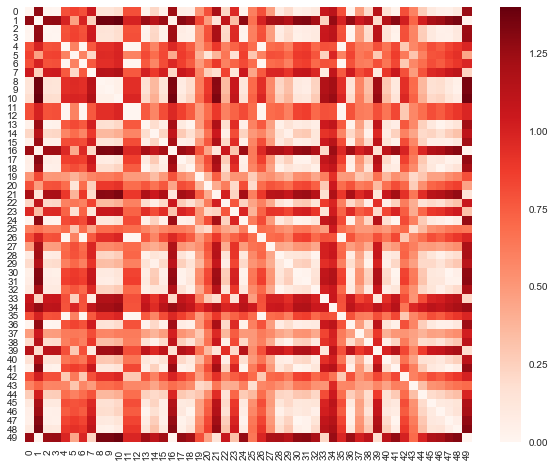

In [39]:
# displaying a subset of the distances matrix :
plt.figure(figsize=[10,8])
sns.heatmap(rel_distances[:50,:50],cmap="Reds");

In [40]:
rel_distance_df = pd.DataFrame(rel_distances, index=rel_data.index.tolist(), columns=rel_data.index.tolist())
rel_distance_df

,AW,AF,AO,AI,AX,AL,AD,AE,AR,AM,...,VG,VI,VN,VU,WF,WS,YE,ZA,ZM,ZW
AW,0.000000,1.279536,0.010000,0.002000,0.802000,0.850556,0.802000,1.041414,0.139442,0.134000,...,0.021954,0.128000,0.731280,0.022000,0.188000,0.118000,1.274867,0.365308,0.153000,0.041000
AF,1.279536,0.000000,1.273292,1.278284,0.997000,0.461654,0.997000,0.253513,1.370405,1.367518,...,1.272812,1.363418,1.001939,1.293439,1.405030,1.356617,0.006000,1.074846,1.380592,1.305626
AO,0.010000,1.273292,0.000000,0.008000,0.792000,0.843128,0.792000,1.034603,0.149345,0.144000,...,0.019026,0.138000,0.721340,0.032000,0.198000,0.128000,1.268600,0.355317,0.163000,0.051000
AI,0.002000,1.278284,0.008000,0.000000,0.800000,0.849066,0.800000,1.040048,0.141421,0.136000,...,0.021024,0.130000,0.729292,0.024000,0.190000,0.120000,1.273609,0.363310,0.155000,0.043000
AX,0.802000,0.997000,0.792000,0.800000,0.000000,0.591365,0.000000,0.765310,0.940213,0.936000,...,0.791228,0.930000,0.108936,0.824000,0.990000,0.920000,0.991000,0.437257,0.955000,0.843000
AL,0.850556,0.461654,0.843128,0.849066,0.591365,0.000000,0.591365,0.208166,0.958057,0.954627,...,0.842603,0.949807,0.579004,0.867078,0.998585,0.941803,0.456070,0.614056,0.969978,0.881541
AD,0.802000,0.997000,0.792000,0.800000,0.000000,0.591365,0.000000,0.765310,0.940213,0.936000,...,0.791228,0.930000,0.108936,0.824000,0.990000,0.920000,0.991000,0.437257,0.955000,0.843000
AE,1.041414,0.253513,1.034603,1.040048,0.765310,0.208166,0.765310,0.000000,1.140395,1.137241,...,1.034100,1.132784,0.763248,1.056577,1.177964,1.125389,0.247913,0.821848,1.151445,1.069864
AR,0.139442,1.370405,0.149345,0.141421,0.940213,0.958057,0.940213,1.140395,0.000000,0.020396,...,0.151532,0.022361,0.868831,0.117712,0.053852,0.028284,1.366046,0.503621,0.025000,0.099040
AM,0.134000,1.367518,0.144000,0.136000,0.936000,0.954627,0.936000,1.137241,0.020396,0.000000,...,0.146240,0.006000,0.864617,0.112000,0.054000,0.016000,1.363150,0.499225,0.019000,0.093000


### Government type distances

In [41]:
data = pd.read_pickle(os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '\DataEnriching\data.pickle')
data.reset_index(inplace=True)
data.set_index('ISO2', inplace=True)

In [42]:
gov_type_df = data[['gov_type_num']]

gov_distance_df = pd.DataFrame(columns=gov_type_df.index.tolist())

for country1, value1 in zip(gov_type_df.index.tolist(), gov_type_df['gov_type_num']):
    row = []
    for country1, value2 in zip(gov_type_df.index.tolist(), gov_type_df['gov_type_num']):
        row.append(abs(value1-value2))
    
    
    dictionary = dict(zip(data.index.tolist(), row))
    gov_distance_df = gov_distance_df.append(dictionary, ignore_index=True)
    
gov_distance_df.index = gov_type_df.index
gov_distance_df

,AW,AF,AO,AI,AX,AL,AD,AE,AR,AM,...,VG,VI,VN,VU,WF,WS,YE,ZA,ZM,ZW
ISO2,,,,,,,,,,,,,,,,,,,,,
AW,0.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,...,0.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0
AF,2.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,0.0,0.0,...,2.0,0.0,0.0,2.0,2.0,2.0,1.0,2.0,0.0,0.0
AO,2.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,0.0,0.0,...,2.0,0.0,0.0,2.0,2.0,2.0,1.0,2.0,0.0,0.0
AI,0.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,...,0.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0
AX,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
AL,0.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,...,0.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0
AD,0.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,...,0.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0
AE,0.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,...,0.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0
AR,2.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,0.0,0.0,...,2.0,0.0,0.0,2.0,2.0,2.0,1.0,2.0,0.0,0.0


In [43]:
rel_distance_df.to_pickle('rel_distance_df.pickle')
gov_distance_df.to_pickle('gov_distance_df.pickle')